<a href="https://colab.research.google.com/github/DonnieNarkko/machine_learning_eva/blob/main/cat_dog_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L || echo "Sin GPU"

!pip -q install -U tensorflow-datasets pillow

/bin/bash: line 1: nvidia-smi: command not found
Sin GPU


In [5]:
import os, shutil
from google.colab import files
from pathlib import Path

SAMPLES_DIR = Path("/content/samples")
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

print("Sube tus imágenes (puedes seleccionar varias):")
uploaded = files.upload()
for name in uploaded.keys():
    shutil.move(name, SAMPLES_DIR / name)

print("Imágenes en", SAMPLES_DIR)
!ls -la /content/samples


Sube tus imágenes (puedes seleccionar varias):


Saving gato1.jpeg to gato1.jpeg
Saving gato2.jpeg to gato2.jpeg
Saving perro1.jpeg to perro1.jpeg
Imágenes en /content/samples
total 636
drwxr-xr-x 2 root root   4096 Oct  5 22:47 .
drwxr-xr-x 1 root root   4096 Oct  5 22:47 ..
-rw-r--r-- 1 root root 307343 Oct  5 22:47 gato1.jpeg
-rw-r--r-- 1 root root  54988 Oct  5 22:47 gato2.jpeg
-rw-r--r-- 1 root root 270615 Oct  5 22:47 perro1.jpeg


In [6]:
import tensorflow as tf, tensorflow_datasets as tfds
import numpy as np

SEED = 42
IMG_SIZE = (150, 150)
BATCH = 32
EPOCHS = 5
PER_CLASS_TRAIN = 2000  # 2000 gatos + 2000 perros = 4000
PER_CLASS_VAL   = 400   #  400 gatos +  400 perros = 800

AUTOTUNE = tf.data.AUTOTUNE
tf.random.set_seed(SEED); np.random.seed(SEED)

# Carga única del split 'train'
(ds_all,), info = tfds.load("cats_vs_dogs", split=["train"], as_supervised=True, with_info=True)

def balanced_subset(ds, per_class):
    cats = ds.filter(lambda x,y: tf.equal(y, 0)).take(per_class)
    dogs = ds.filter(lambda x,y: tf.equal(y, 1)).take(per_class)
    out  = cats.concatenate(dogs).shuffle(2*per_class, seed=SEED)
    return out

def prep(x, y, augment=False):
    x = tf.image.resize(x, IMG_SIZE)
    x = tf.cast(x, tf.float32) / 255.0
    if augment:
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_brightness(x, 0.1)
    return x, y

train_raw = balanced_subset(ds_all, PER_CLASS_TRAIN)
val_raw   = balanced_subset(ds_all.skip(2*PER_CLASS_TRAIN), PER_CLASS_VAL)

train_ds = (train_raw.map(lambda x,y: prep(x,y,augment=True),  num_parallel_calls=AUTOTUNE)
                    .batch(BATCH).prefetch(AUTOTUNE))
val_ds   = (val_raw.map(  lambda x,y: prep(x,y,augment=False), num_parallel_calls=AUTOTUNE)
                    .batch(BATCH).prefetch(AUTOTUNE))

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "| Val batches:", tf.data.experimental.cardinality(val_ds).numpy())


Train batches: -2 | Val batches: -2


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4915 - loss: 0.7494 - val_accuracy: 0.5362 - val_loss: 0.6930
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4944 - loss: 0.6930 - val_accuracy: 0.5550 - val_loss: 0.6880
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5534 - loss: 0.6881 - val_accuracy: 0.5925 - val_loss: 0.6779
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6059 - loss: 0.6659 - val_accuracy: 0.6162 - val_loss: 0.6297
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 130s 978ms/step - accuracy: 0.6541 - loss: 0.6293 - val_accuracy: 0.6513 - val_loss: 0.6268
Validación — acc: 0.651 | loss: 0.627


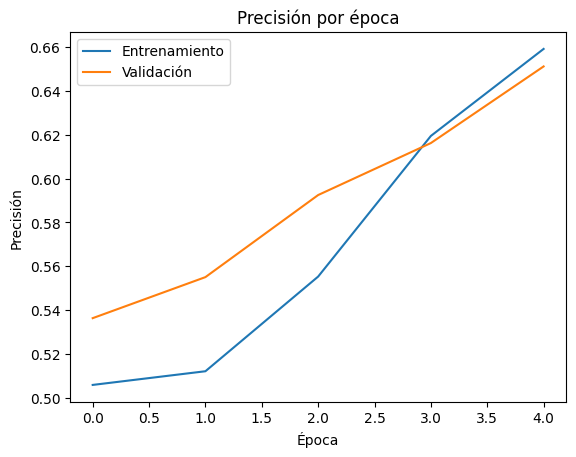

Guardado: /content/cats_vs_dogs_model.keras | /content/cats_vs_dogs.weights.h5


In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file, load_img, img_to_array
from pathlib import Path

MODEL_PATH = "/content/cats_vs_dogs_model.keras"
WEIGHTS_PATH = "/content/cats_vs_dogs.weights.h5"
CLASS_NAMES = ["cat","dog"]

def build_model():
    m = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m

model = build_model()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks)

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validación — acc: {val_acc:.3f} | loss: {val_loss:.3f}")

plt.figure()
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Precisión por época"); plt.xlabel("Época"); plt.ylabel("Precisión"); plt.legend(); plt.show()

model.save(MODEL_PATH)
model.save_weights(WEIGHTS_PATH)
print("Guardado:", MODEL_PATH, "|", WEIGHTS_PATH)


In [9]:
from pathlib import Path

def _prep_image_array(img):
    arr = img_to_array(img)/255.0
    return np.expand_dims(arr, 0)

def predict_array(x):
    p = float(model.predict(x, verbose=0)[0][0])
    idx = 1 if p>=0.5 else 0
    conf = p if idx==1 else (1-p)
    return CLASS_NAMES[idx], conf

def predict_file(path):
    img = load_img(path, target_size=IMG_SIZE)
    x = _prep_image_array(img)
    label, conf = predict_array(x)
    print(f"[FILE] {Path(path).name} -> {label} ({conf*100:.1f}%)")

CARPETA_SAMPLES = "/content/samples"
EXTS = {".jpg", ".jpeg", ".png", ".webp", ".bmp"}

imgs = [p for p in Path(CARPETA_SAMPLES).iterdir() if p.suffix.lower() in EXTS]
print(f"Encontradas {len(imgs)} imágenes en {CARPETA_SAMPLES}")
for f in imgs:
    predict_file(str(f))


Encontradas 4 imágenes en /content/samples
[FILE] perro2.jpg -> dog (82.7%)
[FILE] gato2.jpeg -> dog (64.4%)
[FILE] perro1.jpeg -> dog (77.7%)
[FILE] gato1.jpeg -> cat (55.7%)
